# Prepare VIIRS and ancillary data for RTTOV

### This is used in Figure S2 for creating IASI spectra + per-sensor simulated BTs

Here, the VIIRS I-band BTs are used to simulate a cloud at approximate the right location. The ERA5 data from ECMWF is used to create the atmospheric profile (radiosonde is a bit too noisy for RTTOV to work nicely) and we assume an above-cloud lapse rate of -7.34K/km for the overshooting top.

In [83]:
from Meteo_Scripts.consts import get_avec, get_bvec
import Meteo_Scripts.proc_prof as pp
import matplotlib.pyplot as plt
from datetime import datetime
import Meteo_Scripts.pyr_funcs as pyf
from satpy import Scene
from glob import glob
import xarray as xr
import numpy as np
import pyrttov
import os

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [84]:
# First, set the file location for the various data
# ERA5 data
ecmwf_era5_dir = '/network/aopp/matin/eodg/ecmwf/ERA5/'

# VIIRS SDR data
viirs_data_globber = '/gf2/eodg/SRP001_PROUD_TURBREP/Supercold/VIIRSI/*d20181229_t13*.h5'

# Subsetted ERA5 (input + output)
infile_ml = '../data/Meteo/ML.nc'
infile_sfc = '../data/Meteo/SFC.nc'

# RTTOV dirs
rttov_top, ir_atlas_dir, brdf_atlas_dir, top_rttov_coef = pp.set_rttov_dirs()

# Select actual coefficient files, here for NOAA-20 VIIRS
viirs_rtc = top_rttov_coef + 'rttov9pred54L/rtcoef_noaa_20_viirs.dat'
viirs_cld = top_rttov_coef + 'cldaer_visir/sccldcoef_noaa_20_viirs.dat'

# Size of the VIIRS I-band gridbox centred on the supercold BT
# this value is the half the box width: bbox = [cold_x - val: cold_x+val, cold_y - val: cold_y+val]
grid_half_width = 100

In [85]:
# Set the supercold BT properties
dater = datetime(2018, 12, 29, 13, 38, 0)

yrstr = dater.strftime("%Y")

# Cold pixel location
storm_lat = -3.2609048
storm_lon = 163.2608

# VIIRS viewing geometry.
vza = 7.91
vaa = 360. - 99.311
sza = 41.15
saa = 360. - 146.494

satangs = np.array([vza, vaa, sza, saa], dtype=np.float64).transpose()

In [123]:
# Height estimate is currently unused.
height_est = 20.1  # km

ice_sch = 1  # Baum
ice_parm = 4

# Range of IWC for upper cloud point: min, max, nbins
cir_range = (0, 10, 101)

# Range of cfac for upper cloud point: min, max, nbins
cfr_range = (0.0, 1, 31)

# upper bin for cloud
up_bin = 53 # approx. 75hPa

# tropopause bin
trop_bin = 55

# Number of threads for RTTOV
n_threads = 50

In [124]:
# Retrieve the input profiles from ECMWF data, clouds from above conditions
in_prof, nlevs, nprofs = pp.get_data(infile_ml,
                                    infile_sfc,
                                    storm_lat,
                                    storm_lon,
                                    satangs,
                                    ice_sch,
                                    ice_parm,
                                    cir_range,
                                    cfr_range,
                                    up_bin,
                                    dater)

# Modify the profile based on a typical atmospheric lapse rate. Only points
# above the tropopause are modified. This accounts for overshooting tops.
for i in range(trop_bin, trop_bin-3, -1):
    in_prof.T[:,i] = in_prof.T[:,i+1] - 7.34

In [125]:
# All VIIRS Channels. Note, RTTOV uses weird numbering as it combines I and M bands
chan_list_viirsi = (1, 2, 13, 16, 21)

# Create RTTOV object
viirs_i_rttov, nchan_viirsi = pp.setup_rttov(chan_list_viirsi, viirs_rtc, viirs_cld, in_prof, n_threads)

# Initialise surface conditions
irAtlas, brdfAtlas = pp.init_atlas(ir_atlas_dir, brdf_atlas_dir, in_prof.DateTimes[0][1])
pp.setup_surf_r_e(viirs_i_rttov, nprofs, nchan_viirsi, irAtlas, brdfAtlas)

0
5


Load successful >>>>> inst_id : 1, nchannels : 5.
Deallocating this inst_id.
IR emissivity atlas loaded successfully
BRDF atlas loaded successfully
Atlas deallocated.
Atlas deallocated.


In [126]:
# Run RTTOV itself. Note, this is time consuming.
viirs_i_rttov.runDirect()

### The next section of code finds the best cloud properties model

It uses the RTTOV runs defined in the code above and compares them to VIIRS IR channel information.

You can, in theory, also use the VIS channels (they're simulated by RTTOV) but I found that the simulation
is not great, most likely due to the rather odd cloud we're simulating here. Instead, I just used the I5 band.
This is not ideal, of course, but works reasonably well - especially as all we really want here is a reasonably 
representative cloud top that we can use for the comparison of various satellite BTs + simulated IASI.

In [117]:
# Retrieve the VIIRS I band BTs, even though we don't use I4 it's loaded just in case
infiles = glob(viirs_data_globber)
scn = Scene(infiles, reader='viirs_sdr')
scn.load(['I04', 'I05'])
i4 = np.array(scn['I04'])
i5 = np.array(scn['I05'])

pt = (np.nanmin(i5) == i5).nonzero()
ref_i4 = i4[pt[0][0], pt[1][0]]
ref_i5 = i5[pt[0][0], pt[1][0]]

In [128]:
# Set up output array
ciprof = []  # Best cloud IWC
cfprof = []  # Best cloud fraction
diffs = []   # BT diff between simulated and actual.


# Difference between simulated and actual conditions
i4_d = np.abs(ref_i4 - viirs_i_rttov.BtRefl[:,3])
i5_d = np.abs(ref_i5 - viirs_i_rttov.BtRefl[:,4])

# Total difference. We only look at i5 here as solar irradiance affects
# the i4 band. RTTOV has trouble modelling this as we're dealing with a
# relatively abnormal type of cloud in this study.
delt = np.sqrt(i5_d*i5_d)
# Find the best match between profile and data
minpt = (np.nanmin(delt) == delt).nonzero()[0][0]

# Append best match profiles to the output arrays
ciprof.append(in_prof.Cirr[minpt,:])
cfprof.append(in_prof.Cfrac[minpt,:])
diffs.append(delt[minpt])

# Print some useful information
print("{iv} {jv} {cirr:03.1f} {cfrac:3.2f} {origbt: 7.3f} {outbt:7.3f} {bt1: 7.3f} {bt2: 7.3f} {diff:5.3f}".format(
          iv=i,
          jv=j,
          cirr=in_prof.Cirr[minpt,up_bin],
          cfrac=in_prof.Cfrac[minpt,up_bin],
          origbt=ref_i5,
          outbt=viirs_i_rttov.BtRefl[minpt,4],
          bt1=i4_d[minpt],
          bt2=i5_d[minpt],
          diff=delt[minpt]))

# These arrays contain the best profiles for the I band pixel
ciprof = np.array(ciprof)
cfprof = np.array(cfprof)
diffs = np.array(diffs)

53 199 2.2 0.63  161.955 161.949  39.541   0.006 0.006


In [133]:
# Save these arrays to file, to be used in other scripts
out_arr = xr.Dataset()
out_arr['CIRR'] = (('x','y'), ciprof)
out_arr['CFRAC'] = (('x','y'), cfprof)
out_arr.to_netcdf('../data/Meteo/good_profs_iband.nc')

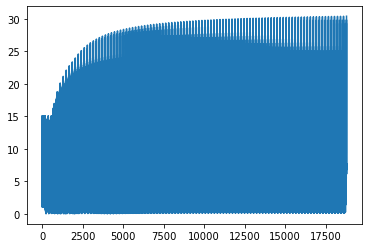

In [134]:
# Plot the differences between simulated and actual BT
# This can be illuminating to see if a particular cloud profile type works better than others
plt.plot(delt)